In [1]:
# Private Preview edition
# ! pip install --index-url=https://pkgs.dev.azure.com/azure-sdk/public/_packaging/azure-sdk-for-python/pypi/simple/ azure-search-documents==11.4.0a20230509004
! pip show azure-search-documents

Name: azure-search-documents
Version: 11.4.0a20230509004
Summary: Microsoft Azure Cognitive Search Client Library for Python
Home-page: https://github.com/Azure/azure-sdk-for-python/tree/main/sdk/search/azure-search-documents
Author: Microsoft Corporation
Author-email: ascl@microsoft.com
License: MIT License
Location: C:\Users\shchitt\AppData\Local\anaconda3\envs\aoai\Lib\site-packages
Requires: azure-common, azure-core, isodate
Required-by: 


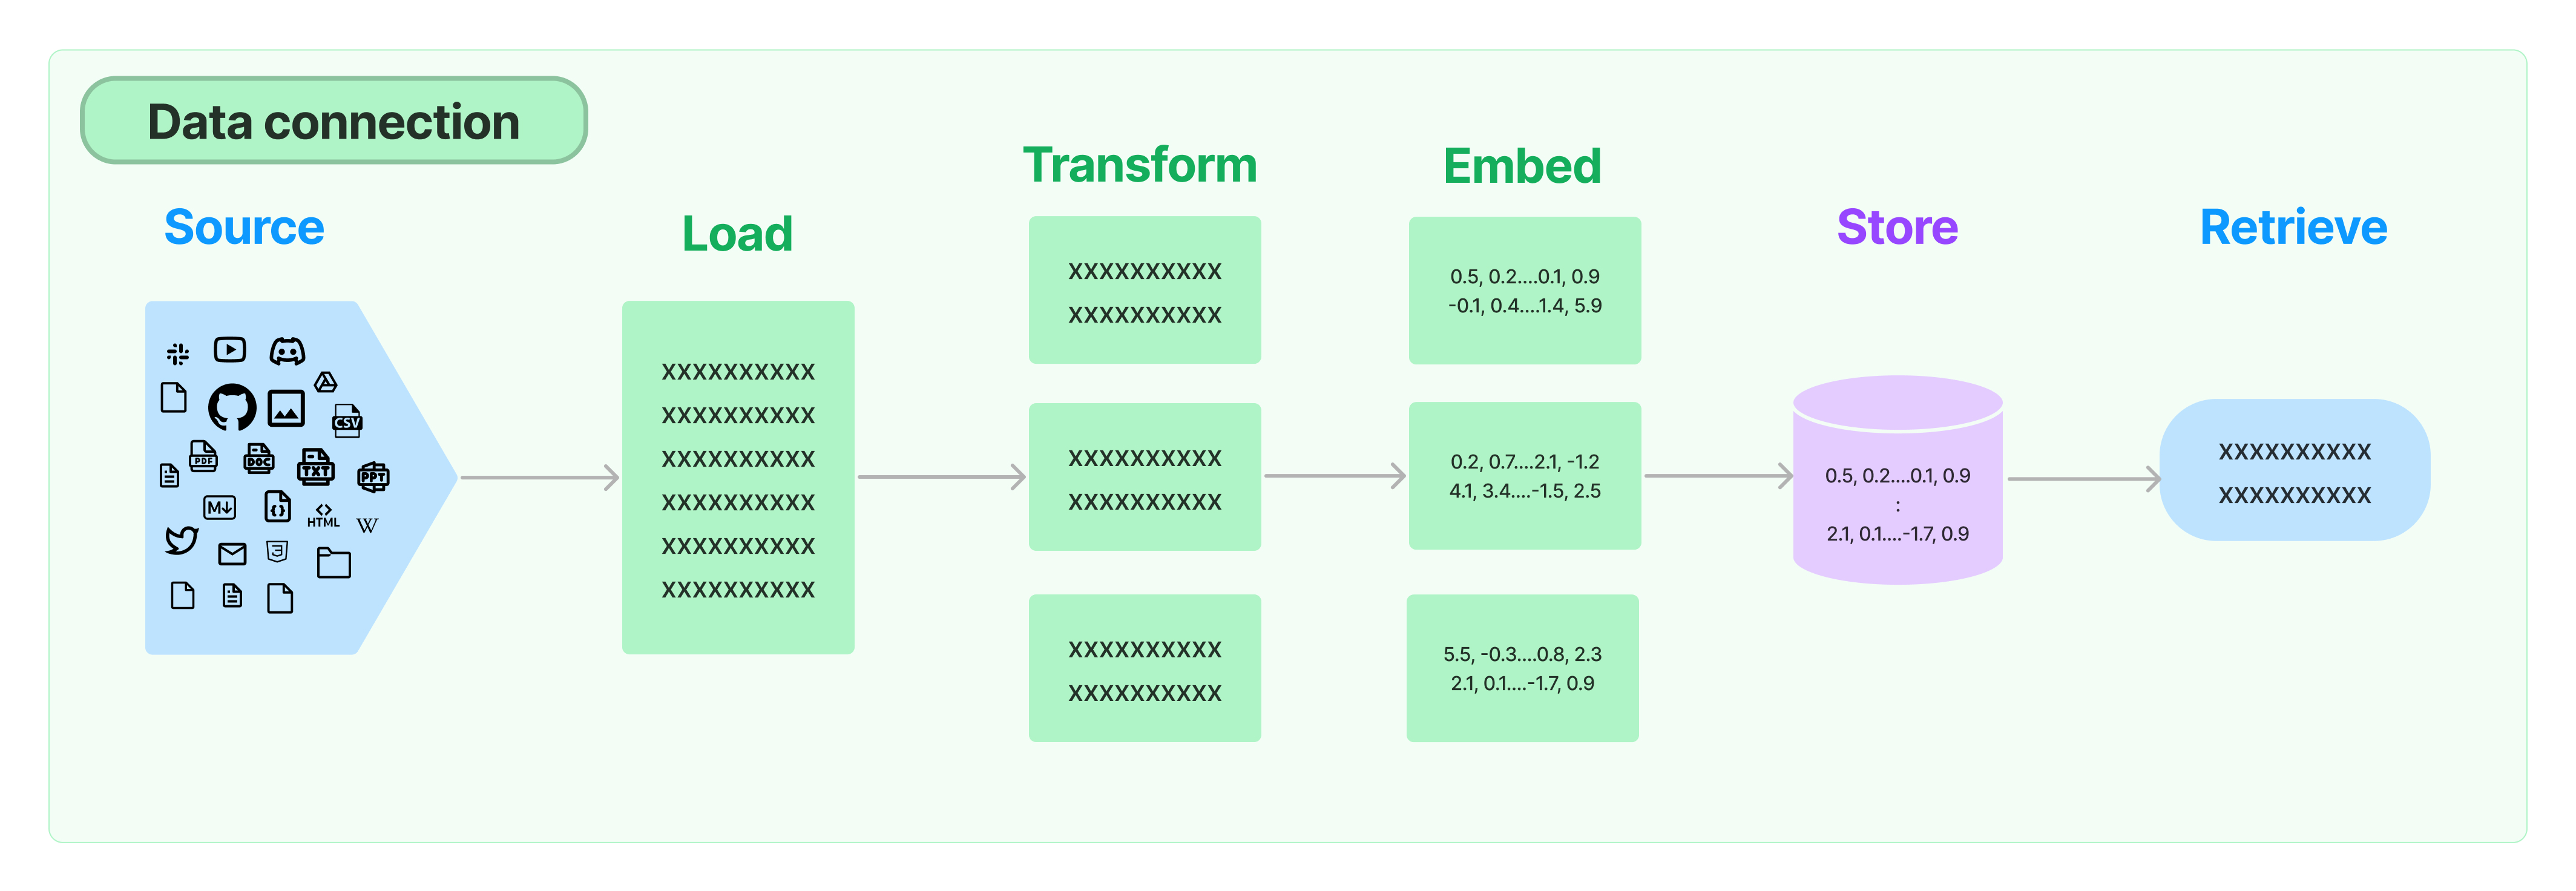

In [1]:
# loading the API keys in environment variables
import os
import os, json
import openai
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.azuresearch import AzureSearch

from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [2]:
openai.api_key = os.environ['OPENAI_API_KEY']
openai.api_base = os.environ['OPENAI_API_BASE']
openai.api_type = os.environ['OPENAI_API_TYPE']
openai.api_version = os.environ['OPENAI_API_VERSION']

chat_model = os.environ['CHAT_MODEL_NAME']
embedding_model = os.environ['EMBEDDING_MODEL_NAME']

In [7]:
embeddings: OpenAIEmbeddings = OpenAIEmbeddings(model=embedding_model, chunk_size=1)
type(embeddings)

langchain.embeddings.openai.OpenAIEmbeddings

In [8]:
vector_store_endpoint: str = os.environ['AZURE_COGNITIVE_SEARCH_ENDPOINT']
vector_store_password: str = os.environ['AZURE_COGNITIVE_SEARCH_KEY']
index_name: str = "langchain-rag-demo"

vector_store: AzureSearch = AzureSearch(
    azure_search_endpoint=vector_store_endpoint,
    azure_search_key=vector_store_password,
    index_name=index_name,
    embedding_function=embeddings.embed_query,
)

In [9]:
from langchain.document_loaders import UnstructuredFileLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter

# loader = UnstructuredFileLoader("files/state_of_the_union.txt")
loader = TextLoader("files/state_of_the_union.txt", encoding="utf-8")
documents = loader.load()
len(documents)

1

In [10]:

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=0)
docs = text_splitter.split_documents(documents)
len(docs)

42

In [11]:
vector_store.add_documents(documents=docs)

['Mzc0NmQxZjMtYjgyNi00ODJkLWE4YjItOGZhNTQ2MzAyZjEx',
 'OWMyZjE0ZmUtOWI1ZS00NWI3LThhZWUtNGYxMTQ0NjY2Nzkw',
 'YTU4MzIwOGMtOTBjZS00NjY2LWIxYWMtMWIzZDhkNmNhOWY4',
 'ZThlMWU5MGYtZmI2Yy00NzhmLTkwMGQtOTVlOTVhY2RjYTdl',
 'NTY0MDNjOTctNmE3Ni00MDEwLWE5OTctYTcxMTUwNWQxNjZl',
 'ZmZmOGFlMGItZWFhNS00ODRlLWE4NTgtYzMwZGQxMDQxN2Fm',
 'ZDZlMjBmYjAtZTM2OC00NWMwLTljMjctYjQ5ODk5NzBkZWJh',
 'NTlkYWYxNmQtYTdkZS00YmQ1LWEyZjUtNTUxNjhlOTk4OWM2',
 'NWMwZTE2ZDctMzQyNC00YTA3LWE3NjAtZTBiMGE3NDQ2MDNi',
 'ZTNkYWM3ODktZWVkNC00NjA4LTkwMjMtZDQ0YTVlZGRiYWUw',
 'NDMwMmYxNTYtODc4Yy00Nzk2LWI4NzUtMWY4ZDNlZWFiNzUy',
 'Yjk3MDA1YTgtNjQ2Yy00NjMzLWJhOWQtZTdkYzZkYTBhM2Fk',
 'YTVkNjhlMmItZGJkOS00YjEwLWEzYjEtNDEwMDcyNTU0ZWNk',
 'NDhlOWY5MGItNjg2Ny00NTIwLTg0ZjItODA3ZDQ1ZDI4N2Zi',
 'YTM2OGRkY2YtNDRhMi00MjViLWIwNDQtYzc5OWQ5NmM5MWJh',
 'NjkyNzYyYTQtYmVhNy00MGYwLWI0OWQtNGU4NjI1N2JhOWRj',
 'NWFjZWY3YmUtYzNlYS00MmY4LWIwMGYtM2FlMDk0ZjI3NzA4',
 'MDRkZDE0NGEtODAzYS00YmY5LWJjYjMtNTVkMzZiYmJlZWNl',
 'ZjRhNzU3YTItNGE0OC00ZjBkLWJkOWQtMTM3NGJjMjlk

In [12]:
from langchain.chat_models import AzureChatOpenAI
from langchain.schema import (
    AIMessage,
    HumanMessage,
    SystemMessage
)

chat = AzureChatOpenAI(temperature=0.0,
    max_tokens=500,
    openai_api_base=openai.api_base,
    openai_api_version=openai.api_version,
    deployment_name=chat_model,
    openai_api_key=openai.api_key,
    openai_api_type = openai.api_type    
)

### Let's try without using memory first! 

We can use RetrievalQA for that as it only focuses on "query" and "context" and does not require "chat_history". 

In [32]:
from langchain.chains import RetrievalQA

retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 5})
retrieval_chain = RetrievalQA.from_chain_type(llm=chat, chain_type="stuff", retriever=retriever)

print("Chat with your docs!")
while True:
    query = input()
    if query in ["quit", "exit"]:
        break
    result = retrieval_chain({"query": query})
    print("User:")
    print(result['query'])
    print("AI:")
    print(result['result'])

Chat with your docs!
User:
What did the president say about Ketanji Brown Jackson?
AI:
The President nominated Circuit Court of Appeals Judge Ketanji Brown Jackson to serve on the United States Supreme Court, and he described her as one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence.
User:
Did he mention who she succeeded?
AI:
No, he did not mention who she succeeded.


In [14]:
# Using Memory object to track chat_history

from langchain.chains import ConversationalRetrievalChain

retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 5})

from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(memory_key="chat_history", return_messages=True)

qa_chain = ConversationalRetrievalChain.from_llm(
    llm=chat,
    retriever=retriever,
    memory=memory,
    chain_type="stuff",
    verbose=False
)

print("Chat with your docs!")
while True:
    query = input()
    result = qa_chain({"question": query})
    if query in ["quit", "exit"]:
        break
    print("User:")
    print(result["question"])
    print("AI:")
    print(result["answer"])
    

Chat with your docs!
User:
What did the president say about Ketanji Brown Jackson?
AI:
The President nominated Circuit Court of Appeals Judge Ketanji Brown Jackson to serve on the United States Supreme Court, and he described her as one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence.
User:
Did he mention who she succeeded?
AI:
The President mentioned Justice Stephen Breyer as the predecessor of Ketanji Brown Jackson.


In [58]:
# pass in chat_history explicity without using Memory object

from langchain.chains import ConversationalRetrievalChain

retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k': 5})
qa_chain_ch = ConversationalRetrievalChain.from_llm(
    llm=chat,
    retriever=retriever,
    chain_type="stuff",
    verbose=False,
    # return_source_documents=True # enable this for source documents
)

In [45]:
chat_history = []
query = "What did the president say about Ketanji Brown Jackson?"
result = qa_chain_ch({"question": query, "chat_history": chat_history})
print(result["answer"], "\n")
print(result["chat_history"])

The President nominated Circuit Court of Appeals Judge Ketanji Brown Jackson to serve on the United States Supreme Court, and he described her as one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence. 

[]


In [46]:
# chat_history = [(query, result["answer"])]
chat_history.append((query, result["answer"]))
query = "Did he mention who she succeeded?"
result = qa_chain_ch({"question": query, "chat_history": chat_history})
print(result["answer"], "\n")
print(result["chat_history"])


The President mentioned Justice Stephen Breyer as the predecessor of Ketanji Brown Jackson. 

[('What did the president say about Ketanji Brown Jackson?', "The President nominated Circuit Court of Appeals Judge Ketanji Brown Jackson to serve on the United States Supreme Court, and he described her as one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence.")]


In [55]:
chat_history.append((query, result["answer"]))
query = "Did he say anything about sanctions on russia?"
result = qa_chain_ch({"question": query, "chat_history": chat_history})
print(result["answer"], "\n")
print(result["chat_history"])

Yes, the President mentioned that the United States, together with its allies, is enforcing powerful economic sanctions on Russia. They are cutting off Russia's largest banks from the international financial system, preventing Russia's central bank from defending the Russian Ruble, and choking off Russia's access to technology that will sap its economic strength and weaken its military for years to come. Additionally, the U.S. Department of Justice is assembling a dedicated task force to go after the crimes of Russian oligarchs, and they are joining with European allies to find and seize their ill-begotten gains. 

[('What did the president say about Ketanji Brown Jackson?', "The President nominated Circuit Court of Appeals Judge Ketanji Brown Jackson to serve on the United States Supreme Court, and he described her as one of the nation's top legal minds who will continue Justice Breyer's legacy of excellence."), ('Did he mention who she succeeded?', 'The President mentioned Justice St